#### Summary: 
In this notebook we will combine all links from the three methods into one bedpe output file per cell type and then perform basic comparisons between methods, and make some plots.

Inputs:
- SMORES outputs and reprocessed ABC and Cicero outputs (all bedpe files)

# 1. Basic Preparation

In [1]:
# Import necessary libraries
suppressMessages(library(tidyverse))
suppressMessages(library(stringr))
suppressMessages(library(data.table))
suppressMessages(library(grid))

suppressMessages(library(tictoc))
suppressMessages(library(UpSetR))
suppressMessages(library(cicero))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))

In [2]:
# Define celltypes list
celltypes <- c('beta','alpha','delta','gamma','ductal','acinar')

# Define colors for each celltype (same order as celltypes)
colors <- c('#3F98E0', '#F51646', '#E39E14', '#A1D99B', '#09850B', '#F5DE6C')

In [16]:
method_colors <- c('#000000', #All 3 links (black)
            '#99C899', #ABC + Cicero (green)
            '#E8A082', #HM + Cicero (orange)
            '#999BD1', #HM + ABC (purple)
            '#E8CD4A', #Cicero (yellow)
            '#4AC3E8', #ABC (blue)
            '#E773B9') #HM (pink)

link_methods <- c('hm_abc_cic','abc_cic','hm_cic','hm_abc','cic','abc','hm')
names(method_colors) <- link_methods

In [3]:
set.seed(8)

### Define necessary reference files

In [ ]:
# read in the gene coords ref file
ref_df <- read.table('non-diabetic-islet-multiomics/references/gene_coords.gencodev32.hg38.bed', sep='\t', header=FALSE) #read in gene coords ref
promoter_df <- read.table('non-diabetic-islet-multiomics/references/gene_coords.gencodev32.hg38.TSS500bp.bed', sep='\t', header=FALSE) #read in promoter ref

### Establish file naming practices for links files

In [5]:
# SMORES links (CP cut) = hm_prefix2 + celltype + hm_suffix2
hm_prefix <- '/dir/with/smores/CP/outputs/'
hm_suffix1 <- '_sig_CP_links.bedpe'
hm_suffix2 <- '_all_CP_links.bedpe'

# Processed ABC links
abc_indir <- '/dir/with/ABC/reprocessed/outputs'
abc_outdir <- '/overall/dir/with/initial/ABC/outputs'

# Processed Cicero links
cic_indir <- '/dir/with/Cicero/reprocessed/outputs'

In [6]:
# ABC background files = abc_bg_dir + celltype + abc_bg_suffix
abc_bg_dir <- '/dir/with/reprocesed/ABC/background/files'
abc_bg_suffix <- '_nonsig_mapped_links.bedpe'

# Cicero background files = cic_bg_dir + celltype + cic_bg_suffix
cic_bg_dir <- '/dir/with/reprocessed/Cicero/background/files'
cic_bg_suffix <- '_links.final_filt.bedpe'

In [10]:
overlap_dir <- '/dir/to/save/merged/links/outputs'
overlap_suffix <- '_all_methods_links.wHeader.bedpe'

# 2. Make one summary bedpe file with all links per cell type
Columns:
- Left coords: cRE (coords from merged overlap, should be what we're already using)
- Right coords: gene promoter (just 1bp window from ref_df (actual TSS)
- Gene name
- Method scores (SMORES, ABC, Cicero), NA if not found by method
- Found methods (string of all link methods which found this link)

In [137]:
### Function to process links into a common format list
get_formatted_links <- function(row){
    cre = paste(row[[1]],row[[2]],row[[3]],sep='-')
    gene = row[[7]]
    return(paste(cre,gene,sep="_"))
}

In [138]:
### Function to pull the necessary sig link score for a cRE-gene pair in a links df
get_link_score <- function(row, method_col, link_df){
    # Pull out relevant info for the link method of choice
    link <- paste(paste(row[[1]],row[[2]],row[[3]],sep='-'),row[[7]],sep='_')

    # Check if the link is found in the method of interest
    found <- ifelse(row[[method_col]] == 1, TRUE, FALSE)
    if (found == TRUE){
        # Get link score (if more than one link due to mapping overlap, take top score)
        if(dim(link_df[link_df$links==link,])[1] > 1){
            score <- max(link_df[link_df$links==link,]$V8)
        } else {
            score <- link_df[link_df$links==link,]$V8
        }
    } else {
        score <- NA
    }
    return(score)
}

In [139]:
### Function to compare the celltype links from 3 methods using Upset (returns upset object for further work)
### Also writes outputs to files (using _ not - or & to separate link method names!!!)

### New method that makes combined bedpe for all sig links per cell type (with info on which methods they were called in)
compare_links_write_bedpe <- function(celltype, tss_df, overlap_outdir){
    # Set up file paths for each links set
    hm_fp <- paste0(hm_prefix, celltype, hm_suffix1)
    abc_fp <- file.path(abc_indir, sprintf('%s_mapped_links.bedpe',celltype))
    cic_fp <- file.path(cic_indir, sprintf('%s_links.CP_reformat.bedpe',celltype))
    
    # Read in links and convert to basic format (add links info back to dfs for use later)
    hm_df <- read.table(hm_fp, sep='\t')
    hm_links <- gsub(" ","",apply(hm_df, 1, get_formatted_links))
    hm_df$links <- hm_links
    print(paste0('Total number of HM links: ', length(hm_links)))
    abc_df <- read.table(abc_fp, sep='\t')
    abc_links <- gsub(" ","",apply(abc_df, 1, get_formatted_links))
    abc_df$links <- abc_links
    print(paste0('Total number of ABC links: ', length(abc_links)))
    cic_df <- read.table(cic_fp, sep='\t')
    cic_links <- gsub(" ","",apply(cic_df, 1, get_formatted_links))
    cic_df$links <- cic_links
    print(paste0('Total number of Cicero links: ', length(cic_links)))
    
    # Make Upset plot object
    listInput <- list(hm = hm_links, abc = abc_links, cic=cic_links)
    p1 <- upset(fromList(listInput), order.by = "degree", sets.x.label="Links datasets",
                text.scale=c(1.5,1.5,1.5,1.5,2,2), point.size=5, line.size=2) #, main.bar.color=colors) 
    
    # Pull out links overlap table (which sets each link appears in)
    overlaps <- p1$New_data
    all_links <- unlist(listInput, use.names=FALSE)
    all_links <- all_links[!duplicated(all_links)]
    row.names(overlaps) <- all_links
    
    # Get cRE coords into columns
    all_links_coords <- str_split_fixed(all_links,'_',2)[,1]
    coords <- str_split_fixed(all_links_coords, '-', 3)
    colnames(coords) <- c('chr','start','end')
    overlaps_fin <- cbind(coords, overlaps)

    # Get gene coords from the TSS df
    overlaps_fin$gene <- str_split_fixed(row.names(overlaps_fin),'_',2)[,2]
    bedpe <- cbind(overlaps_fin[,c(1,2,3)], tss_df[overlaps_fin$gene,], overlaps_fin[,c(7,4,5,6)])
    
    # Extract link scores from each method (takes about 10mins)
    bedpe$hm_score <- unlist(apply(bedpe, 1, get_link_score, 8, hm_df))
    bedpe$abc_score <- unlist(apply(bedpe, 1, get_link_score, 9, abc_df))
    bedpe$cic_score <- unlist(apply(bedpe, 1, get_link_score, 10, cic_df))
    
    # Create a max score column (for genome browser don't want any NAs in score col)
    scores <- bedpe[,c(11,12,13)]
    bedpe$max_score <- unlist(apply(scores, 1, max, na.rm=T))

    # Add column with string of which method/s called the link
    methods <- c('hm_abc_cic','hm_abc','hm_cic','abc_cic','hm','abc','cic')
    names(methods) <- c('111','110','101','011','100','010','001')
    methods_bin <- paste0(as.character(bedpe$hm),as.character(bedpe$abc),as.character(bedpe$cic))
    bedpe$method_str <- methods[methods_bin]

    #rm binary columns and put max score before the other scores
    bedpe_fin <- bedpe[,c(1,2,3,4,5,6,7,14,11,12,13,15)] 

    #write to a file
    fp1 <- file.path(overlap_dir,sprintf('%s_all_methods_links.bedpe',celltype))
    write.table(bedpe_fin,fp1,sep='\t',row.names=F,col.names=F,quote=F)

    #also write version with header
    fp2 <- gsub('links.bedpe','links.wHeader.bedpe',fp1)
    write.table(bedpe_fin,fp2,sep='\t',row.names=F,col.names=T,quote=F)
}

In [140]:
# Build gene TSS coords reference -- should be +249 and +250 (to get 0-indexed, what the epigenome browser does) 
promoter_df$tss <- paste(promoter_df$V1, promoter_df$V2 + 250, promoter_df$V2 + 251, sep='-')
tss_df <- as.data.frame(str_split_fixed(promoter_df$tss, '-', 3))
colnames(tss_df) <- c('chr2','start2','end2')
row.names(tss_df) <- promoter_df$V4
head(tss_df)

,chr2,start2,end2
,<chr>,<chr>,<chr>
MIR1302-2HG,chr1,29554,29555
FAM138A,chr1,36081,36082
OR4F5,chr1,65419,65420
AL627309.1,chr1,133723,133724
AL627309.3,chr1,91105,91106
AL627309.2,chr1,140339,140340


In [141]:
for (celltype in celltypes){
    tic()
    compare_links_write_bedpe(celltype, tss_df, overlap_outdir2)
    toc()
}

# 3. Make an overall summary barplot (all cell types)

In [13]:
# Read in all cell type plots and summarize number of links for each type of overlap
link_distribs <- list()
for (celltype in celltypes){
    fp <- paste0(overlap_dir,'/',celltype,overlap_suffix)
    df <- read.table(fp, sep='\t', header=1)
    link_distribs[[celltype]] <- table(df$method_str)
}

In [14]:
data <- as_tibble(link_distribs) %>% mutate(set=names(link_distribs[[1]])) %>%
            pivot_longer(cols=!set, names_to="celltype", values_to="links") %>%
            mutate(links2=as.integer(links))

In [17]:
#map link sets to names for output
link_methods2 <- c('hm_abc_cic','hm_abc','hm_cic','abc_cic','hm','abc','cic')
id_map <- c('SMORES-ABC-Cicero', 'SMORES-ABC', 'SMORES-Cicero', 'ABC-Cicero', 'SMORES only', 'ABC only', 'Cicero only')
names(id_map) <- link_methods2
data$set2 <- plyr::mapvalues(x=data$set, from=names(id_map), to=id_map)
#head(data)

#also make alt color vector
method_colors2 <- copy(method_colors)
names(method_colors2) <- id_map

Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."
Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."


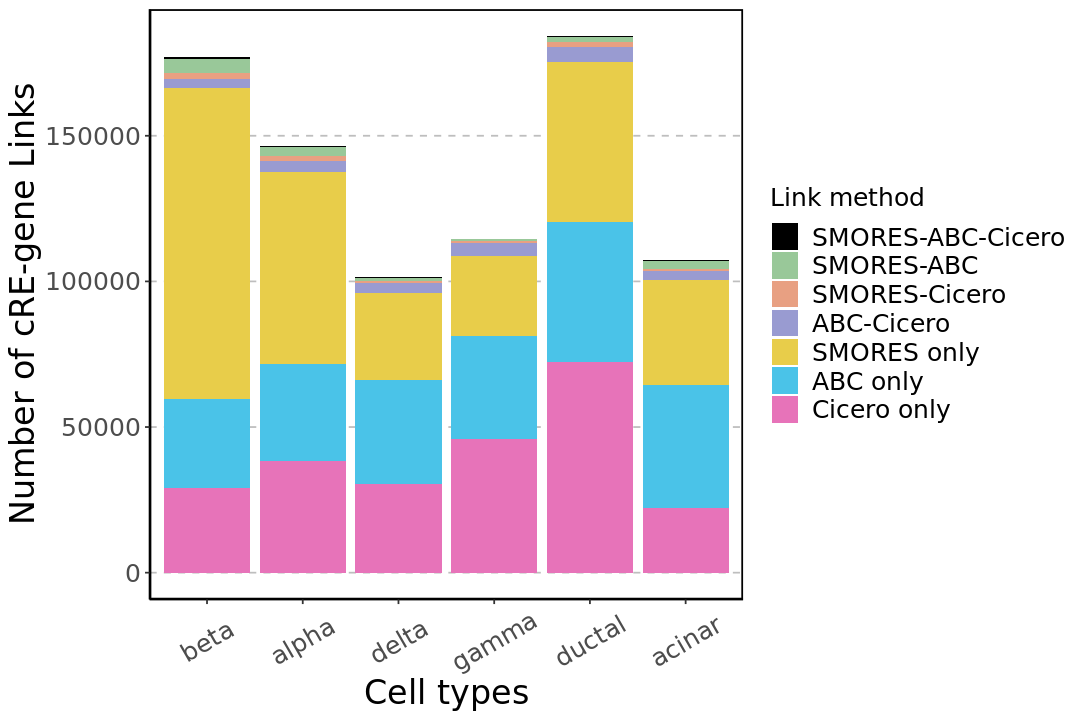

In [18]:
options(repr.plot.width=9, repr.plot.height=6)
theme_set(theme_classic())
p1 <- ggplot(data, aes(fill=set2, y=links2, x=celltype)) + 
        geom_bar(position='stack', stat='identity') +
        scale_fill_manual(values=method_colors2) + labs(fill='Link method') + 
        ylab('Number of cRE-gene Links') + xlab('Cell types') + 
        theme(axis.title=element_text(size=20),
              axis.text.y=element_text(size=15),
              axis.text.x=element_text(size=15, angle=30, vjust=0.5),
              legend.title=element_text(size=15),
              legend.text=element_text(size=15),
              panel.grid.major.y=element_line(color='grey', size=0.5, linetype=2),
              panel.border=element_rect(color='black',fill=NA, size=1))
p1$data$celltype <- factor(x = p1$data$celltype, levels = celltypes)
p1$data$set2 <- factor(x=p1$data$set2, levels=id_map)
p1

# 4. Compare Methods Distribution of Distances

In [19]:
### Function to calculate link distances from a bedpe style dataframe row
calc_link_distance <- function(link_df_row){
    CRE_start <- as.integer(link_df_row[2])
    CRE_end <- as.integer(link_df_row[3])
    gene_start <- as.integer(link_df_row[5])
    CRE_center <- CRE_start + (CRE_end - CRE_start)/2
    distance <- abs(CRE_center - gene_start)
    return(distance)
}

In [21]:
### One cell type example
celltype <- 'beta'

#read in links
fp <- paste0(overlap_dir,'/',celltype,overlap_suffix)
df <- read.table(fp, sep='\t', header=1)

# Get link distances for each method
distances1 <- unlist(apply(subset(df, !is.na(hm_score)), 1, calc_link_distance))
distances2 <- unlist(apply(subset(df, !is.na(abc_score)), 1, calc_link_distance))
distances3 <- unlist(apply(subset(df, !is.na(cic_score)), 1, calc_link_distance))

# Make ggplot2 formatted dataframe
data <- data.frame(distance = c(distances1, distances2, distances3),
                   method = c(rep('hm', dim(subset(df, !is.na(hm_score)))[1]), rep('abc', dim(subset(df, !is.na(abc_score)))[1]), rep('cic', dim(subset(df, !is.na(cic_score)))[1])))
distance_cap <- 750000
data$distance[data$distance>distance_cap] <- distance_cap
#head(data)

#make per bin summary dataframe
distance_bins <- c('250000-1000000', '100000-250000', '50000-100000', '10000-50000', '0-10000')
meta <- data %>% group_by(method) %>% 
        mutate(bin1=sum(distance<10000), bin2=sum(distance>=10000 & distance<50000),
               bin3=sum(distance>=50000 & distance<100000),bin4=sum(distance>=100000 & distance<250000),
               bin5=sum(distance>=250000)) %>% 
        select(-distance) %>%
        distinct(method, .keep_all=TRUE) %>% pivot_longer(!method, names_to='distance_bin', values_to='count') %>%
        mutate(distance_bin2=plyr::mapvalues(distance_bin, from=c('bin1','bin2','bin3','bin4','bin5'),to=rev(distance_bins))) %>%
        mutate(Method=plyr::mapvalues(method, from=c('hm','abc','cic'), to=c('SMORES','ABC','Cicero')))
#head(meta)

The following `from` values were not present in `x`: hm, cic

The following `from` values were not present in `x`: hm, abc

The following `from` values were not present in `x`: abc, cic



In [22]:
method_colors3 <- c('SMORES'='#E773B9','ABC'='#4AC3E8','Cicero'='#E8CD4A')

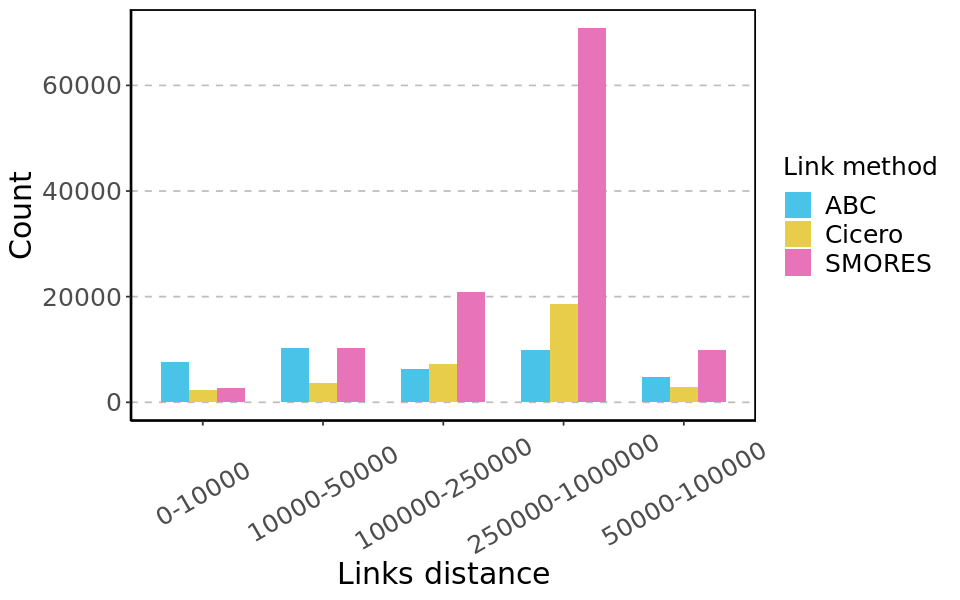

In [23]:
options(repr.plot.width=8, repr.plot.height=5)
theme_set(theme_classic())

p1 <- ggplot(meta, aes(x=distance_bin2, y=count, fill=Method)) + 
        geom_bar(stat='identity', position=position_dodge(0.7), width=0.7) + 
        scale_fill_manual(values=method_colors3) + 
        ylab('Count') + xlab('Links distance') + labs(fill='Link method') + 
        theme(title=element_blank(),
              axis.title=element_text(size=18),
              axis.text.x=element_text(size=15, angle=30, vjust=0.5),axis.text.y=element_text(size=15),
              legend.title=element_text(size=15),
              legend.text=element_text(size=15),
              panel.grid.major.y=element_line(color='grey', size=0.5, linetype=2),
              panel.border=element_rect(color='black',fill=NA, size=1))
p1

# 5. Compare the number of genes with different numbers of links by methods

In [24]:
### Function to summarize number of links per gene for a link method
summarize_links_per_gene <- function(links_df, method_col, cap=20){
    links_per_gene <- links_df %>% subset(!is.na(df[,method_col])) %>% mutate(cre=paste(chr,start,end,sep='-')) %>%
                        group_by(gene) %>% mutate(links_per_gene=length(unique(cre))) %>% select(gene,links_per_gene) %>% 
                        distinct(gene, .keep_all=T) %>% pull(links_per_gene)
    link_data <- data.frame(links_per_gene=links_per_gene, method=gsub('_score','',method_col))
    link_data$links_per_gene_cap <- ifelse(link_data$links_per_gene > cap, cap, link_data$links_per_gene)
    return(link_data)
}

In [26]:
#one cell type example
celltype <- 'beta'
fp <- paste0(overlap_dir,'/',celltype,overlap_suffix)
df <- read.table(fp, sep='\t', header=1)

#get # links per gene by method
summaries <- list()
for(method_col in c('hm_score','abc_score','cic_score')){
    summaries[[method_col]] <- summarize_links_per_gene(df, method_col, 20)
}

data <- rbindlist(summaries)
dim(data)

#make per bin summary dataframe
bins <- c(0,5,10,15,20)
meta <- data %>% group_by(method) %>% 
        mutate(bin0_5=sum(links_per_gene_cap<5), bin5_10=sum(links_per_gene_cap>=5 & links_per_gene_cap<10),
               bin10_15=sum(links_per_gene_cap>=10 & links_per_gene_cap<15),bin15_20=sum(links_per_gene_cap>=15 & links_per_gene_cap<20),
               bin20=sum(links_per_gene_cap>=20)) %>% 
        select(-links_per_gene,-links_per_gene_cap) %>%
        distinct(method, .keep_all=TRUE) %>% pivot_longer(!method, names_to='num_targets', values_to='count') %>%
        mutate(targets=plyr::mapvalues(num_targets, from=c('bin0_5','bin5_10','bin10_15','bin15_20','bin20'),to=c('0-5','5-10','10-15','15-20','20+'))) %>%
        mutate(Method=plyr::mapvalues(method, from=c('hm','abc','cic'), to=c('SMORES','ABC','Cicero')))
head(meta)

[1] 39847     3

The following `from` values were not present in `x`: hm, cic

The following `from` values were not present in `x`: hm, abc

The following `from` values were not present in `x`: abc, cic



method,num_targets,count,targets,Method
<chr>,<chr>,<int>,<chr>,<chr>
hm,bin0_5,10167,0-5,SMORES
hm,bin5_10,2853,5-10,SMORES
hm,bin10_15,1223,10-15,SMORES
hm,bin15_20,743,15-20,SMORES
hm,bin20,1495,20+,SMORES
abc,bin0_5,14084,0-5,ABC


null device 
          1

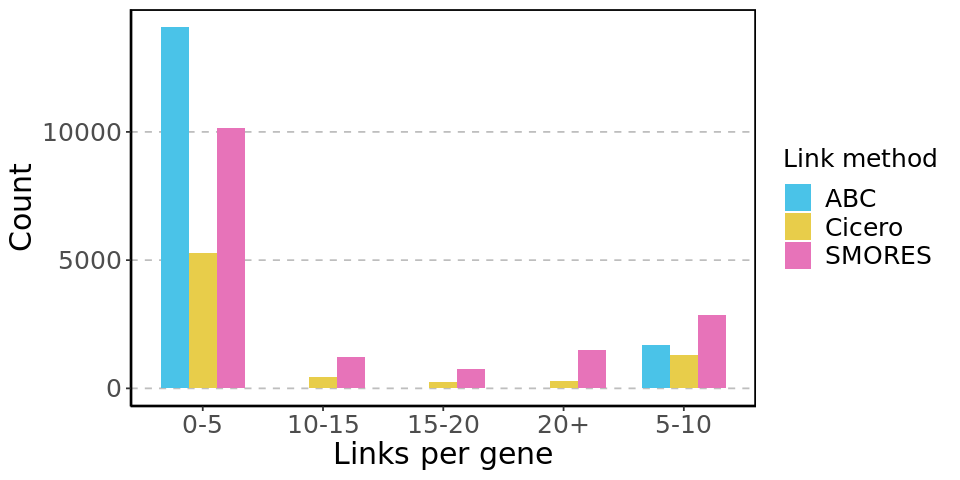

In [27]:
options(repr.plot.width=8, repr.plot.height=4)
theme_set(theme_classic())

p1 <- ggplot(meta, aes(x=targets, y=count, fill=Method)) + 
        geom_bar(stat='identity', position=position_dodge(0.7), width=0.7) + 
        scale_fill_manual(values=method_colors3) + labs(title=celltype, fill='Link method') + 
        ylab('Count') + xlab('Links per gene') + 
        theme(title=element_blank(),
              axis.title=element_text(size=18),
              axis.text=element_text(size=15),
              legend.title=element_text(size=15),
              legend.text=element_text(size=15),
              panel.grid.major.y=element_line(color='grey', size=0.5, linetype=2),
              panel.border=element_rect(color='black',fill=NA, size=1))
print(p1)
dev.off()

In [2]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] splines   stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] RColorBrewer_1.1-3   pheatmap_1.0.12      cicero_1.12.0       
 [4] Gviz_1.38.4          GenomicRanges_1.46.1 GenomeInfoDb_1.30.1 
 [7] IRanges_2.28.0       S4Vectors_0.32.4     monocle_2.22.0      
[10] DDRTree_0.1.5        ir